In [ ]:
pip install scikit-optimize

In [ ]:
pip install imagededup

In [ ]:
pip install scikeras

In [ ]:
!pip install keras-tuner

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from imagededup.methods import PHash
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import shutil
import keras
import keras_tuner as kt
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from scikeras.wrappers import KerasClassifier
from skopt import BayesSearchCV

from tensorflow.keras.applications import ResNet50

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 91.5MB/s]


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/drive/MyDrive/benign_malign_undersampling/train'
validation_dir = '/content/drive/MyDrive/benign_malign_undersampling/validation'

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=48,
        class_mode='binary',
        seed=42,
        shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary',
        seed=42,
        shuffle=False)

Found 3920 images belonging to 2 classes.
Found 789 images belonging to 2 classes.


In [29]:
import tensorflow.keras.backend as K
K.clear_session()

# MODEL 1

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
callbacks_list = [keras.callbacks.EarlyStopping (monitor='val_loss', mode='min', patience=5, restore_best_weights=True)]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['Recall', 'Precision', 'AUC', 'Accuracy']
)


history = model.fit(
      train_generator,
      epochs=20,
      callbacks = callbacks_list,
      validation_data=validation_generator,
      )

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 81s 852ms/step - AUC: 0.8564 - Accuracy: 0.7798 - Precision: 0.7771 - Recall: 0.7917 - loss: 0.6910 - val_AUC: 0.5000 - val_Accuracy: 0.6768 - val_Precision: 0.6768 - val_Recall: 1.0000 - val_loss: 2.4984
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 71s 807ms/step - AUC: 0.9105 - Accuracy: 0.8298 - Precision: 0.8254 - Recall: 0.8358 - loss: 0.4010 - val_AUC: 0.5503 - val_Accuracy: 0.6730 - val_Precision: 0.6756 - val_Recall: 0.9944 - val_loss: 1.2423
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 71s 807ms/step - AUC: 0.9359 - Accuracy: 0.8531 - Precision: 0.8427 - Recall: 0.8763 - loss: 0.3276 - val_AUC: 0.6963 - val_Accuracy: 0.7541 - val_Precision: 0.7648 - val_Recall: 0.9195 - val_loss: 1.2555
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 71s 804ms/step - AUC: 0.9411 - Accuracy: 0.8644 - Precision: 0.8646 - Recall: 0.8655 - loss: 0.3172 - val_AUC: 0.5469 - val_Accuracy: 0.6793 - val_Precision: 0.6785 - val_Recall: 1.0000 - val_loss: 2.6100
Epoch 5/20
82/82 ━━━━━━━━━━━

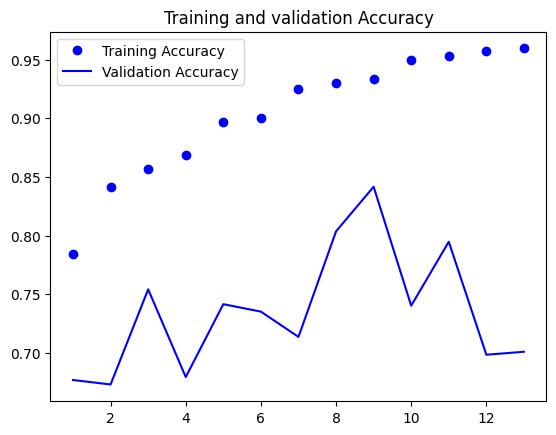

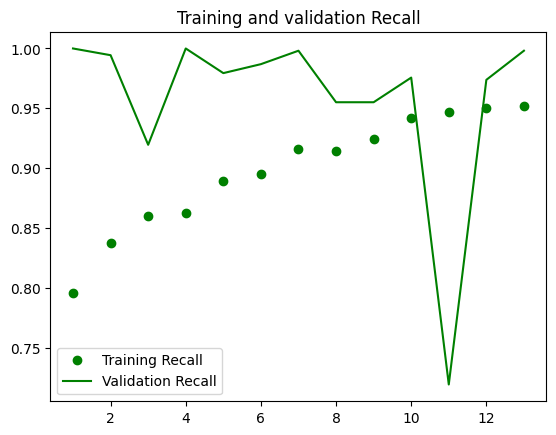

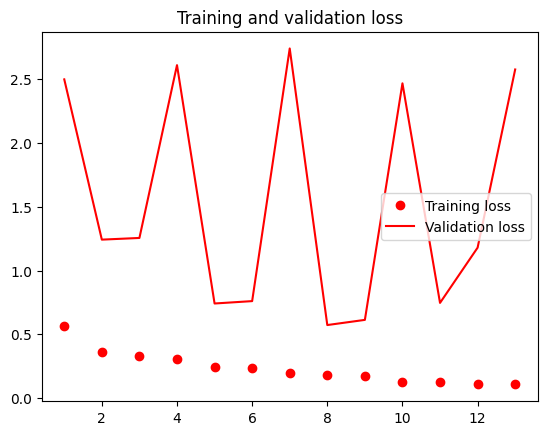

In [12]:
accuracy = history.history['Accuracy']
val_accuracy = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['Recall']
val_recall = history.history['val_Recall']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'go', label='Training Recall')
plt.plot(epochs, val_recall, 'g', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
test_dir = '/content/drive/MyDrive/benign_malign_undersampling/test'

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=48,
    class_mode='binary'
)

Found 790 images belonging to 2 classes.


In [14]:
test_loss, test_accuracy, test_recall, test_auc, test_precision= model.evaluate(test_generator)
print(f"Test Recall: {test_recall}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")
print(f"Test Precision: {test_precision}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - AUC: 0.8676 - Accuracy: 0.7850 - Precision: 0.7763 - Recall: 0.9507 - loss: 0.6682
Test Recall: 0.7871674299240112
Test Loss: 0.6580982804298401
Test Accuracy: 0.9490566253662109
Test AUC: 0.8654789328575134
Test Precision: 0.7936708927154541


In [17]:
y_true = test_generator.classes

y_pred_probabilities = model.predict(test_generator)

17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 716ms/step


In [18]:
thresholds = np.arange(0.0, 1.0, 0.05)
for threshold in thresholds:
    y_pred = (y_pred_probabilities  >= threshold).astype(int)
    print(f"Threshold: {threshold}")
    print(confusion_matrix(y_true, y_pred))

Threshold: 0.0
[[  0 260]
 [  0 530]]
Threshold: 0.05
[[  5 255]
 [ 10 520]]
Threshold: 0.1
[[ 16 244]
 [ 22 508]]
Threshold: 0.15000000000000002
[[ 22 238]
 [ 37 493]]
Threshold: 0.2
[[ 24 236]
 [ 44 486]]
Threshold: 0.25
[[ 30 230]
 [ 56 474]]
Threshold: 0.30000000000000004
[[ 35 225]
 [ 62 468]]
Threshold: 0.35000000000000003
[[ 40 220]
 [ 71 459]]
Threshold: 0.4
[[ 46 214]
 [ 79 451]]
Threshold: 0.45
[[ 50 210]
 [ 89 441]]
Threshold: 0.5
[[ 56 204]
 [ 95 435]]
Threshold: 0.55
[[ 60 200]
 [102 428]]
Threshold: 0.6000000000000001
[[ 63 197]
 [113 417]]
Threshold: 0.65
[[ 66 194]
 [123 407]]
Threshold: 0.7000000000000001
[[ 68 192]
 [133 397]]
Threshold: 0.75
[[ 77 183]
 [138 392]]
Threshold: 0.8
[[ 82 178]
 [151 379]]
Threshold: 0.8500000000000001
[[ 88 172]
 [162 368]]
Threshold: 0.9
[[ 96 164]
 [175 355]]
Threshold: 0.9500000000000001
[[108 152]
 [206 324]]


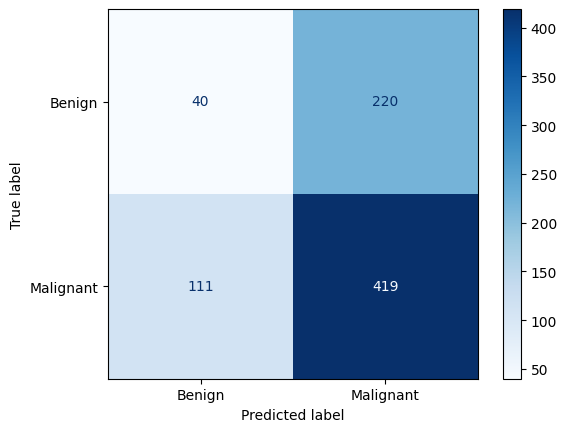

In [16]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap='Blues')

In [ ]:
model.save('/content/drive/MyDrive/benign_malignant_small_1st.h5')

# MODEL 2, Class_Weights, Data Augmentation and Callbacks

In [32]:
model_test = models.Sequential()

model_test.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_test.add(layers.BatchNormalization())
model_test.add(layers.MaxPooling2D((2, 2)))
model_test.add(layers.Dropout(0.3))

model_test.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_test.add(layers.BatchNormalization())
model_test.add(layers.MaxPooling2D((2, 2)))
model_test.add(layers.Dropout(0.3))

model_test.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_test.add(layers.BatchNormalization())
model_test.add(layers.MaxPooling2D((2, 2)))
model_test.add(layers.Dropout(0.3))

# Global Pooling
model_test.add(layers.GlobalAveragePooling2D())

# Fully Connected Layers
model_test.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_test.add(layers.Dropout(0.5))
model_test.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/drive/MyDrive/benign_malign_undersampling/train'
validation_dir = '/content/drive/MyDrive/benign_malign_undersampling/validation'

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=48,
        class_mode='binary',
        seed=42,
        shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary',
        seed=42,
        shuffle=False)

Found 3920 images belonging to 2 classes.
Found 789 images belonging to 2 classes.


In [35]:
callbacks_list = [keras.callbacks.EarlyStopping (monitor='val_loss', mode='min', patience=3, restore_best_weights=True)]

model_test.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['Recall', 'Precision', 'AUC', 'Accuracy']
)


history_test = model_test.fit(
      train_generator,
      epochs=20,
      callbacks = callbacks_list,
      validation_data=validation_generator,
      )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 101s 979ms/step - AUC: 0.8474 - Accuracy: 0.7756 - Precision: 0.7609 - Recall: 0.7945 - loss: 2.8817 - val_AUC: 0.5431 - val_Accuracy: 0.6768 - val_Precision: 0.6768 - val_Recall: 1.0000 - val_loss: 1.7577
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 74s 836ms/step - AUC: 0.9041 - Accuracy: 0.8085 - Precision: 0.7785 - Recall: 0.8566 - loss: 1.2770 - val_AUC: 0.5106 - val_Accuracy: 0.6768 - val_Precision: 0.6768 - val_Recall: 1.0000 - val_loss: 1.1420
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 73s 832ms/step - AUC: 0.9124 - Accuracy: 0.8256 - Precision: 0.8077 - Recall: 0.8514 - loss: 0.7635 - val_AUC: 0.5739 - val_Accuracy: 0.6768 - val_Precision: 0.6768 - val_Recall: 1.0000 - val_loss: 1.0570
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 73s 829ms/step - AUC: 0.9195 - Accuracy: 0.8351 - Precision: 0.8212 - Recall: 0.8571 - loss: 0.5653 - val_AUC: 0.7274 - val_Accuracy: 0.6768 - val_Precision: 0.6768 - val_Recall: 1.0000 - val_loss: 1.3748
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 

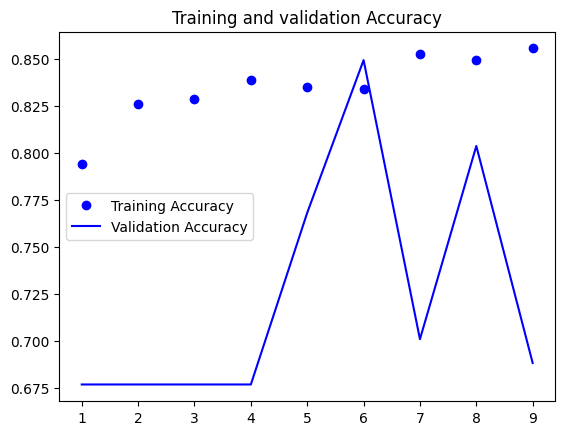

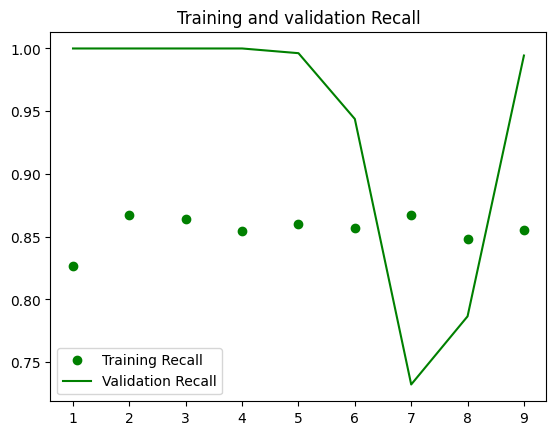

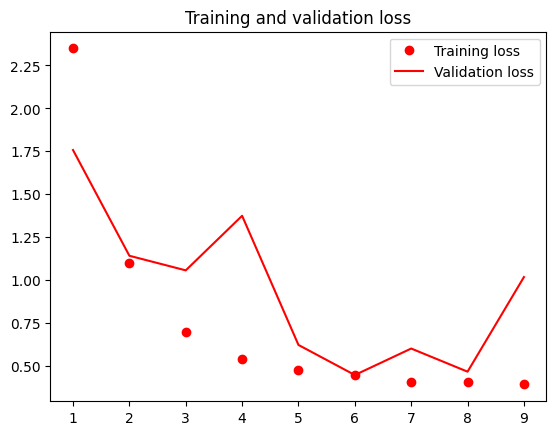

In [36]:
accuracy = history_test.history['Accuracy']
val_accuracy = history_test.history['val_Accuracy']
loss = history_test.history['loss']
val_loss = history_test.history['val_loss']
recall = history_test.history['Recall']
val_recall = history_test.history['val_Recall']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'go', label='Training Recall')
plt.plot(epochs, val_recall, 'g', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
test_dir = '/content/drive/MyDrive/benign_malign_undersampling/test'

test_datagen_test = ImageDataGenerator(rescale=1.0/255)
test_generator_test = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=48,
    class_mode='binary'
)

Found 790 images belonging to 2 classes.


In [38]:
y_true = test_generator_test.classes

y_pred_probabilities_test = model_test.predict(test_generator_test)
y_pred_test = (y_pred_probabilities_test > 0.5).astype(int)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 816ms/step


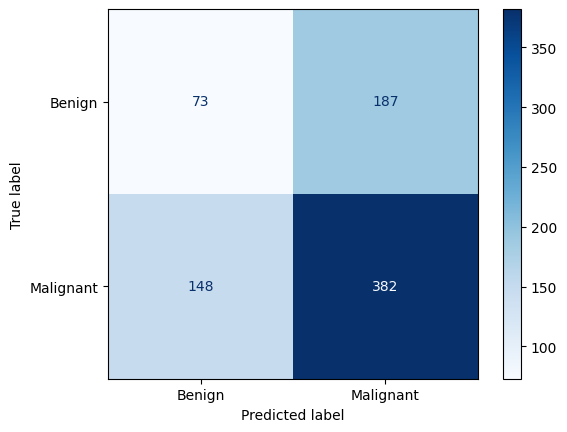

In [39]:
cm = confusion_matrix(y_true, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator_test.class_indices.keys())
disp.plot(cmap='Blues')

In [40]:
model_test.save('/content/drive/MyDrive/benign_malignant_under_test.h5')